# Estimating COVID-19's $R_t$ in Real-Time
_all text published by Kevin Systrom (April 12 2020) unless otherwise stated._

In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) change $R_t$. Knowing the current $R_t$ is essential. When $R>1$, the pandemic will spread through the entire population. If $R_t<1$, the pandemic will grow to some fixed number less than the population. The lower $R_t$, the more manageable the situation. The value of $R_t$ helps us (1) understand how effective our measures have been controlling an outbreak and (2) gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.

Yet, today, to my knowledge there is no real-time tracking of $R_t$ in United States. In fact, the only real-time measure I've seen has been for [Hong Kong](https://covid19.sph.hku.hk/dashboard). More importantly, it is not useful to understand $R_t$ at a national level. Instead, to manage this crisis effectively, we need a local (state, county and/or city) level granularity of $R_t$.

What follows is a solution to this problem at the US State level. It's a modified version of a solution created by [Bettencourt & Ribeiro 2008](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) to estimate real-time $R_t$ using a Bayesian approach. While I have stayed true to most of their process, my solution differs in an important way that I will call out clearly.

If you have questions, comments, or improvments feel free to get in touch: [hello@systrom.com](mailto:hello@systrom.com). And if it's not entirely clear, I'm not an epidemiologist. At the same time, data is data, and statistics are statistics and this is based on work by well-known epidemiologists so calibrate accordingly. In the meantime, I hope you can learn something new as I did by reading through this example. Feel free to take this work and apply it elsewhere – internationally or to counties in the United States.

In [1]:
import pandas as pd
import numpy as np
                                                                                                                                                                            
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

## Bettencourt & Ribeiro's Approach

Every day, we learn how many more people have COVID-19. This new case count gives us a clue about the current value of $R_t$. We also, figure that the value of $R_t$ today is related to the value of $R_{t-1}$ (yesterday's value) and every previous value of $R_{t-m}$ for that matter.

With these insights, the authors use [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) to update their beliefs about the true value of $R_t$ based on how many new cases have been reported each day.

This is Bayes' Theorem as we'll use it:

$$ P(R_t|k)=\frac{P(R_t)\cdot\mathcal{L}(R_t|k)}{P(k)} $$

This says that, having seen $k$ new cases, we believe the distribution of $R_t$ is equal to:

- The __prior__ beliefs of the value of $P(R_t)$ without the data ...
- times the __likelihood__ of $R_t$ given that we've seen $k$ new cases ...
- divided by the probability of seeing this many cases in general.

Importantly, $P(k)$ is a constant, so the numerator is proportional to the posterior. Since all probability distributions sum to 1.0, we can ignore $P(k)$ and normalize our posterior to sum to 1.0:

$$ P(R_t|k) \propto P(R_t) \cdot \mathcal{L}(R_t|k) $$

This is for a single day. To make it iterative: every day that passes, we use yesterday's conclusion (ie. posterior) $P(R_{t-1}|k_{t-1})$ to be today's prior $P(R_t)$ so on day two:

$$ P(R_2|k) \propto P(R_0)\cdot\mathcal{L}(R_2|k_2)\cdot\mathcal{L}(R_1|k_1) $$

And more generally:

$$ P(R_t|k_t) \propto P(R_0) \cdot {\displaystyle \prod^{T}_{t=0}}\mathcal{L}(R_t|k_t) $$

With a uniform prior $P(R_0)$, this reduces to:

$$ P(R_t|k_t) \propto {\displaystyle \prod^{T}_{t=0}}\mathcal{L}\left(R_t|k_t\right) $$

### My Proposed Modification

This works fine, but it suffers from an issue: the posterior on any given day is equally influenced by the distant past as much as the recent day. For epidemics that have $R_t>1$ for a long time and then become under control ($R_t<1$), the posterior gets stuck. It cannot forget about the many days where $R_t>1$ so eventually $P(R_t|k)$ asymptotically approaches 1 when we know it's well under 1. The authors note this in the paper as a footnote. Unfortunately this won't work for us. __The most critical thing to know is when we've dipped below the 1.0 threshold!__

So, I propose to only incorporate the last $m$ days of the likelihood function. By doing this, the algorithm's prior is built based on the recent past which is a much more useful prior than the entire history of the epidemic. So this simple, but important change leads to the following:

$$ P(R_t|k_t) \propto {\displaystyle \prod^{T}_{t=T-m}}\mathcal{L}\left(R_t|k_t\right) $$

While this takes the last $m$ priors into account equally, you can decide to apply a windowing function (such as an exponential) to favor recent priors over more distant.

### Choosing a Likelihood Function $\mathcal{L}\left(R_t|k_t\right)$

A likelihood function function says how likely a value of $R_t$ is given an observed number of new cases $k$.

Any time you need to model 'arrivals' over some time period of time, statisticians like to use the [Poisson Distribution](https://en.wikipedia.org/wiki/Poisson_distribution). Given an average arrival rate of $\lambda$ new cases per day, the probability of seeing $k$ new cases is distributed according to the Poisson distribution:

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

# Application to Singapore

In [2]:
all_cases = pd.read_csv("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/"\
                     "time_series_covid19_confirmed_global.csv")

# Get only Singapore
COUNTRY = "Singapore"

# Munge
country_cases = all_cases[all_cases["Country/Region"] == COUNTRY].iloc[:,4:].T
country_cases.columns = ["{} cases".format(COUNTRY)]
country_cases = country_cases.reindex(pd.to_datetime(country_cases.index)).iloc[:,0]

In [5]:
most_recent = pd.read_csv("https://docs.google.com/spreadsheets/d/e/"\
                          "2PACX-1vSEsnoFB_UWtY4tM9xPhobtl-L8eY1fW60ba32lUrUn7jVSzRQxeeY-6lH-ogO3nUSHdk1p9PHWUbul/"\
                          "pub?gid=0&single=true&output=csv",
                         index_col=0)

most_recent = most_recent.reindex(pd.to_datetime(most_recent.index))

# most_recent["All"] = country_cases.diff().iloc[-19:]

,Community,WP_dorm,WP_nondorm
date,,,
2020-03-28,18,0,10
2020-03-29,12,2,4
2020-03-30,16,3,5
2020-03-31,21,6,7
2020-04-01,39,13,3
2020-04-02,29,8,4
2020-04-03,29,22,5
2020-04-04,32,27,9
2020-04-05,43,58,15


In [66]:
all_community = pd.concat([country_cases.loc[:"2020-03-27"].diff(), # Because MOH started segregating numbers after 28 March 2020.
                          most_recent.Community] 
                         )

all_cases = pd.concat([all_community,
                       most_recent.WP_dorm, 
                       most_recent.WP_nondorm], 
                      axis=1)

all_cases.rename(columns={0:"Community"}, inplace=True)

all_cases["All"] = all_cases.sum(axis=1)

In [67]:
all_cases

,Community,WP_dorm,WP_nondorm,All
2020-01-22,NaN,NaN,NaN,0.0
2020-01-23,1.0,NaN,NaN,1.0
2020-01-24,2.0,NaN,NaN,2.0
2020-01-25,0.0,NaN,NaN,0.0
2020-01-26,1.0,NaN,NaN,1.0
...,...,...,...,...
2020-04-11,27.0,151.0,13.0,191.0
2020-04-12,26.0,188.0,19.0,233.0
2020-04-13,39.0,333.0,14.0,386.0
2020-04-14,40.0,275.0,19.0,334.0


In [37]:
def prepare_cases_(new_cases, winsize):

    smoothed = new_cases.rolling(winsize,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

Taking a look at the state, we need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we can, I've applied a gaussian filter to the time series. This is obviously an arbitrary choice, but you'd imagine the real world process is not nearly as stochastic as the actual reporting.

### Running the Algorithm

Just like the example before, we create lambda based on the previous day's counts from all values of $R_t$. Unlike the previous example, I now evaluate the __log__ of the Poisson. Why? It makes windowing easier.

Since $\log{ab}=\log{a}+\log{b}$, we can do a rolling sum over the last $m$ periods and then exponentiate to get the rolling product of the original values. This does not change any of the numbers – it's just a convenience.

In [56]:
def get_posteriors(sr, winsize=7, 
                   min_periods=1, 
                   R_T_MAX = 12,
                   GAMMA=1/4):
    
    # We create an array for every possible value of Rt.
    r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)
    
    # Compute the Poisson lambdas for each Rt.
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(winsize,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

In [49]:
def plot_posteriors(posteriors):

    ax = posteriors.plot(title=f'{COUNTRY} - Daily Posterior for $R_t$',
               legend=False, 
               lw=1,
               c='k',
               alpha=.3,
               xlim=(0.4,4))

    ax.set_xlabel('$R_t$');

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [43]:
# Note that this takes a while to execute - it's not the most efficient algorithm
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])



# Takes a while to run.
def get_data_for_rt_plot(posteriors):
    hdis = highest_density_interval(posteriors)

    most_likely = posteriors.idxmax().rename('ML')

    # Look into why you shift -1
    result = pd.concat([most_likely, hdis], axis=1)
    result = result.reindex(result.index.rename("date"))

    return result

In [88]:
# Collate all the computational functions.

def process_data(new_cases, winsize): 
    original, smoothed = prepare_cases_(new_cases, winsize=winsize)
    
    posteriors = get_posteriors(smoothed.dropna(), winsize=winsize)
    
    group_result = get_data_for_rt_plot(posteriors)
    
    return {'raw':original,
            'smoothed': smoothed, 
            'rt': group_result}


def plot_rt(result, ax, COUNTRY):
    
    ax.set_title(f"{COUNTRY}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25, label=COUNTRY)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=index[0],
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    
    fig.set_facecolor('w')    

In [89]:
# Process data for each group

all_data_for_plot = {}

for j, group in enumerate(all_cases.columns):
    print(j+1, group)
    
    if group.startswith("WP"):
        WINSIZE = 4 # days for smoothing window.
    else:
        WINSIZE = 7
        
    all_data_for_plot[group] = process_data(all_cases[group], winsize=WINSIZE)
    
    print(f"{group} processed.")

1 Community
Community processed.
2 WP_dorm
WP_dorm processed.
3 WP_nondorm
WP_nondorm processed.
4 All
All processed.


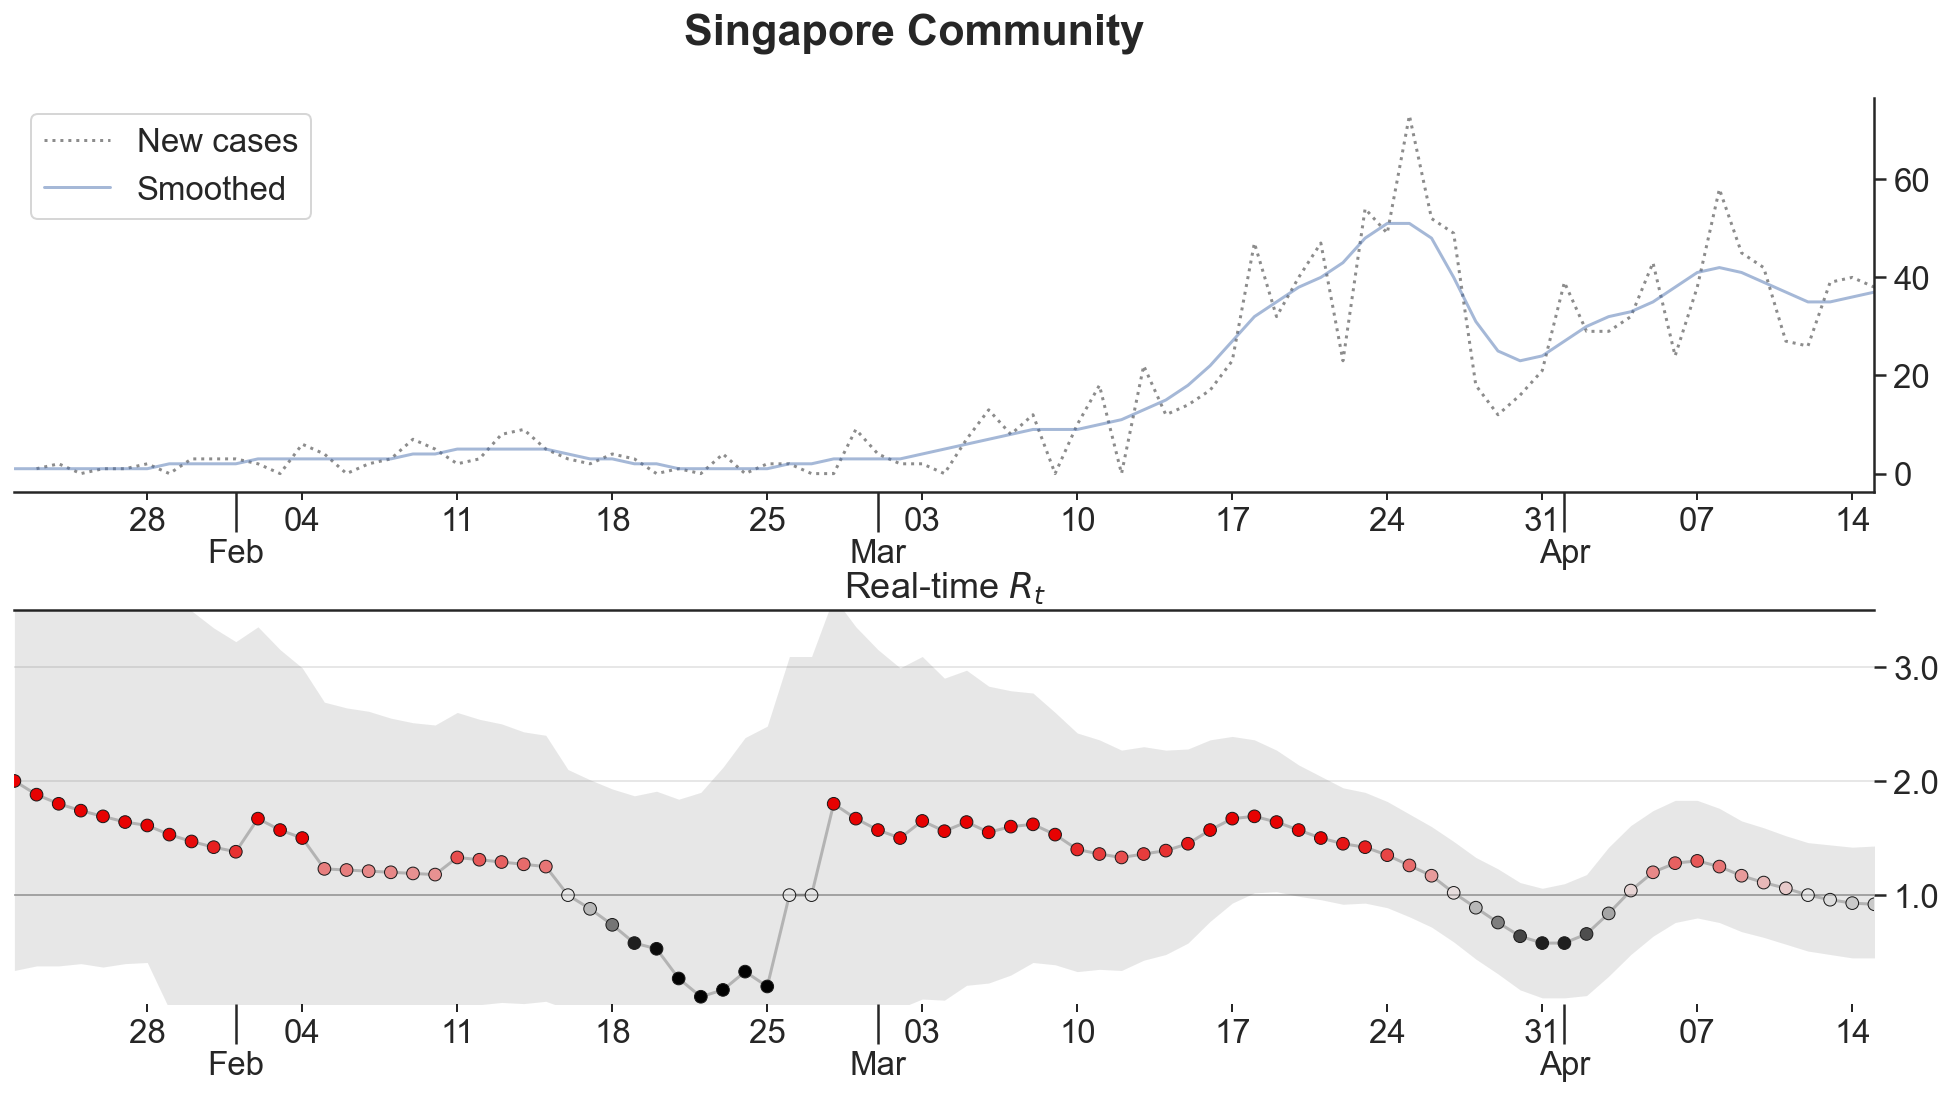

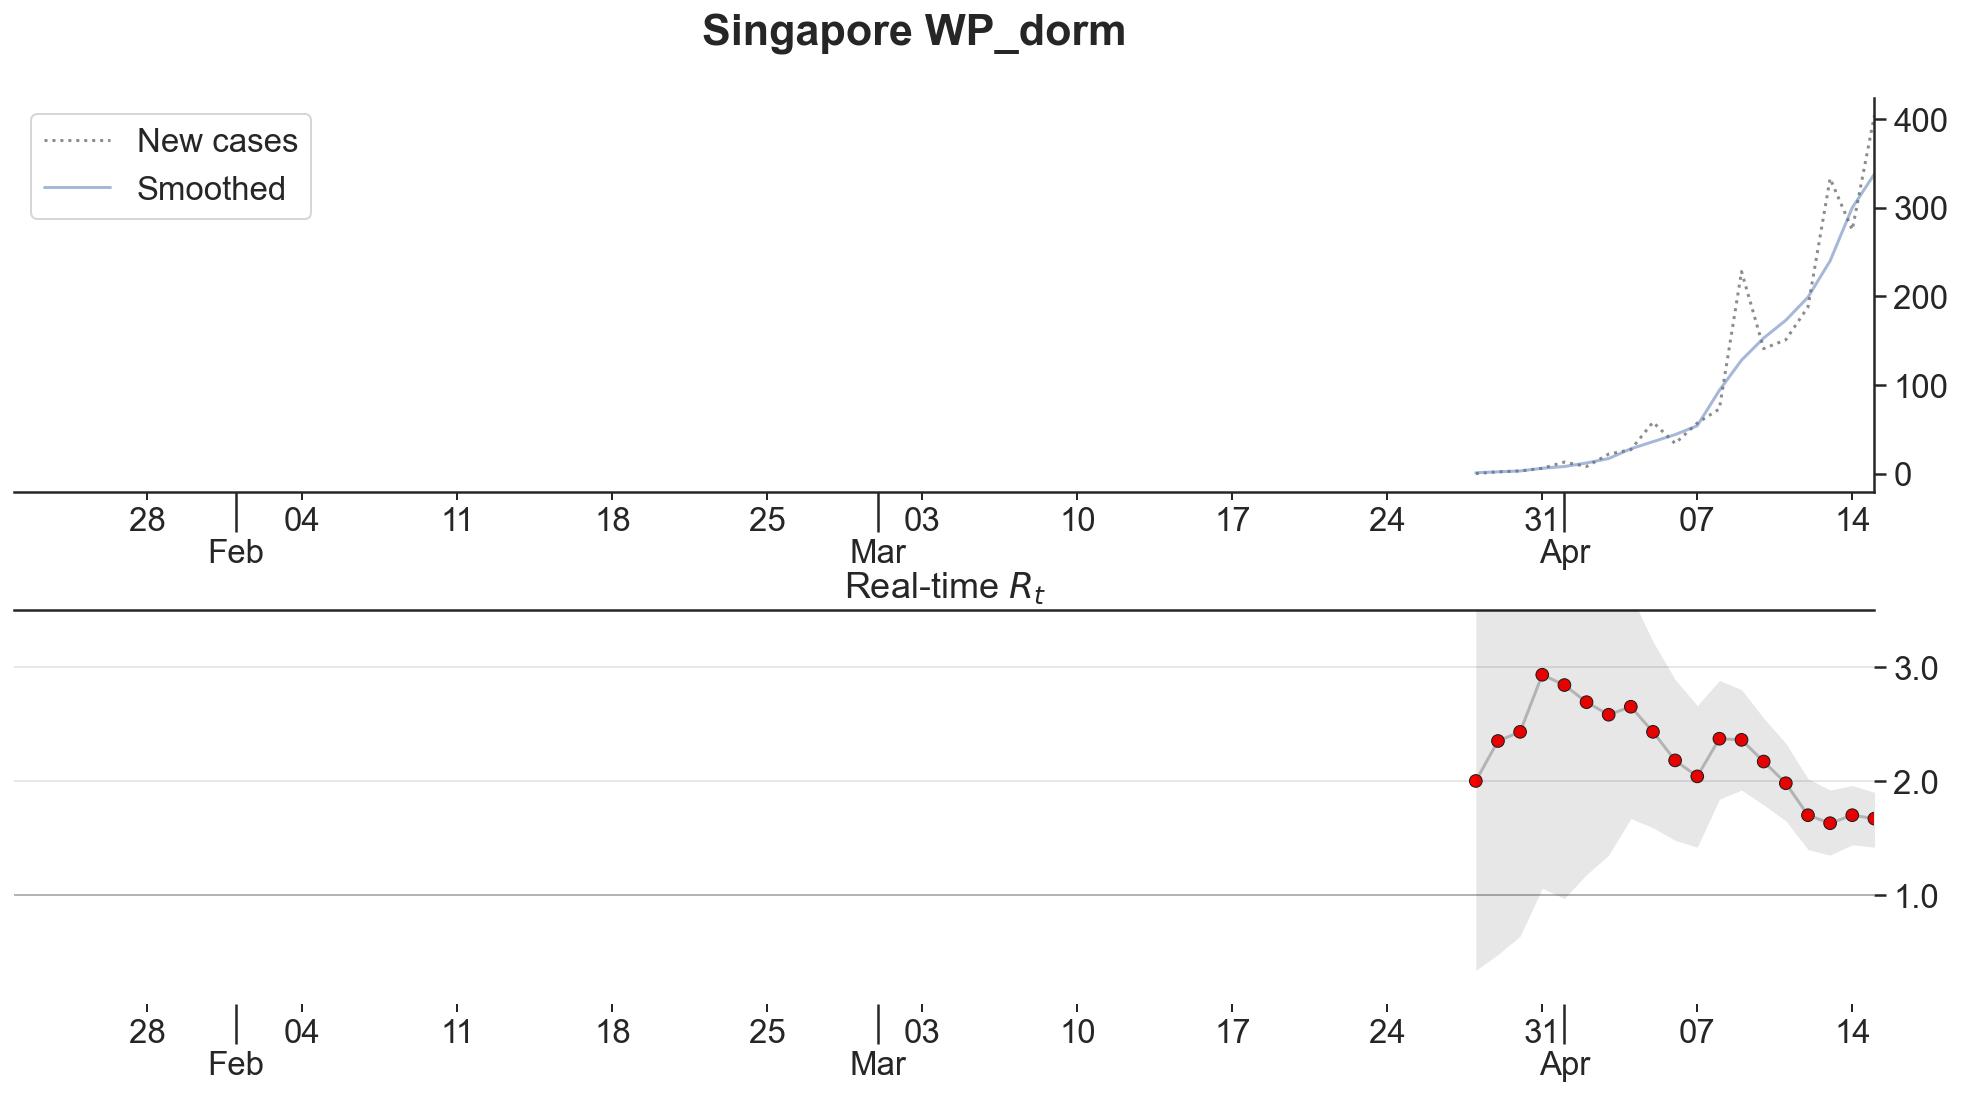

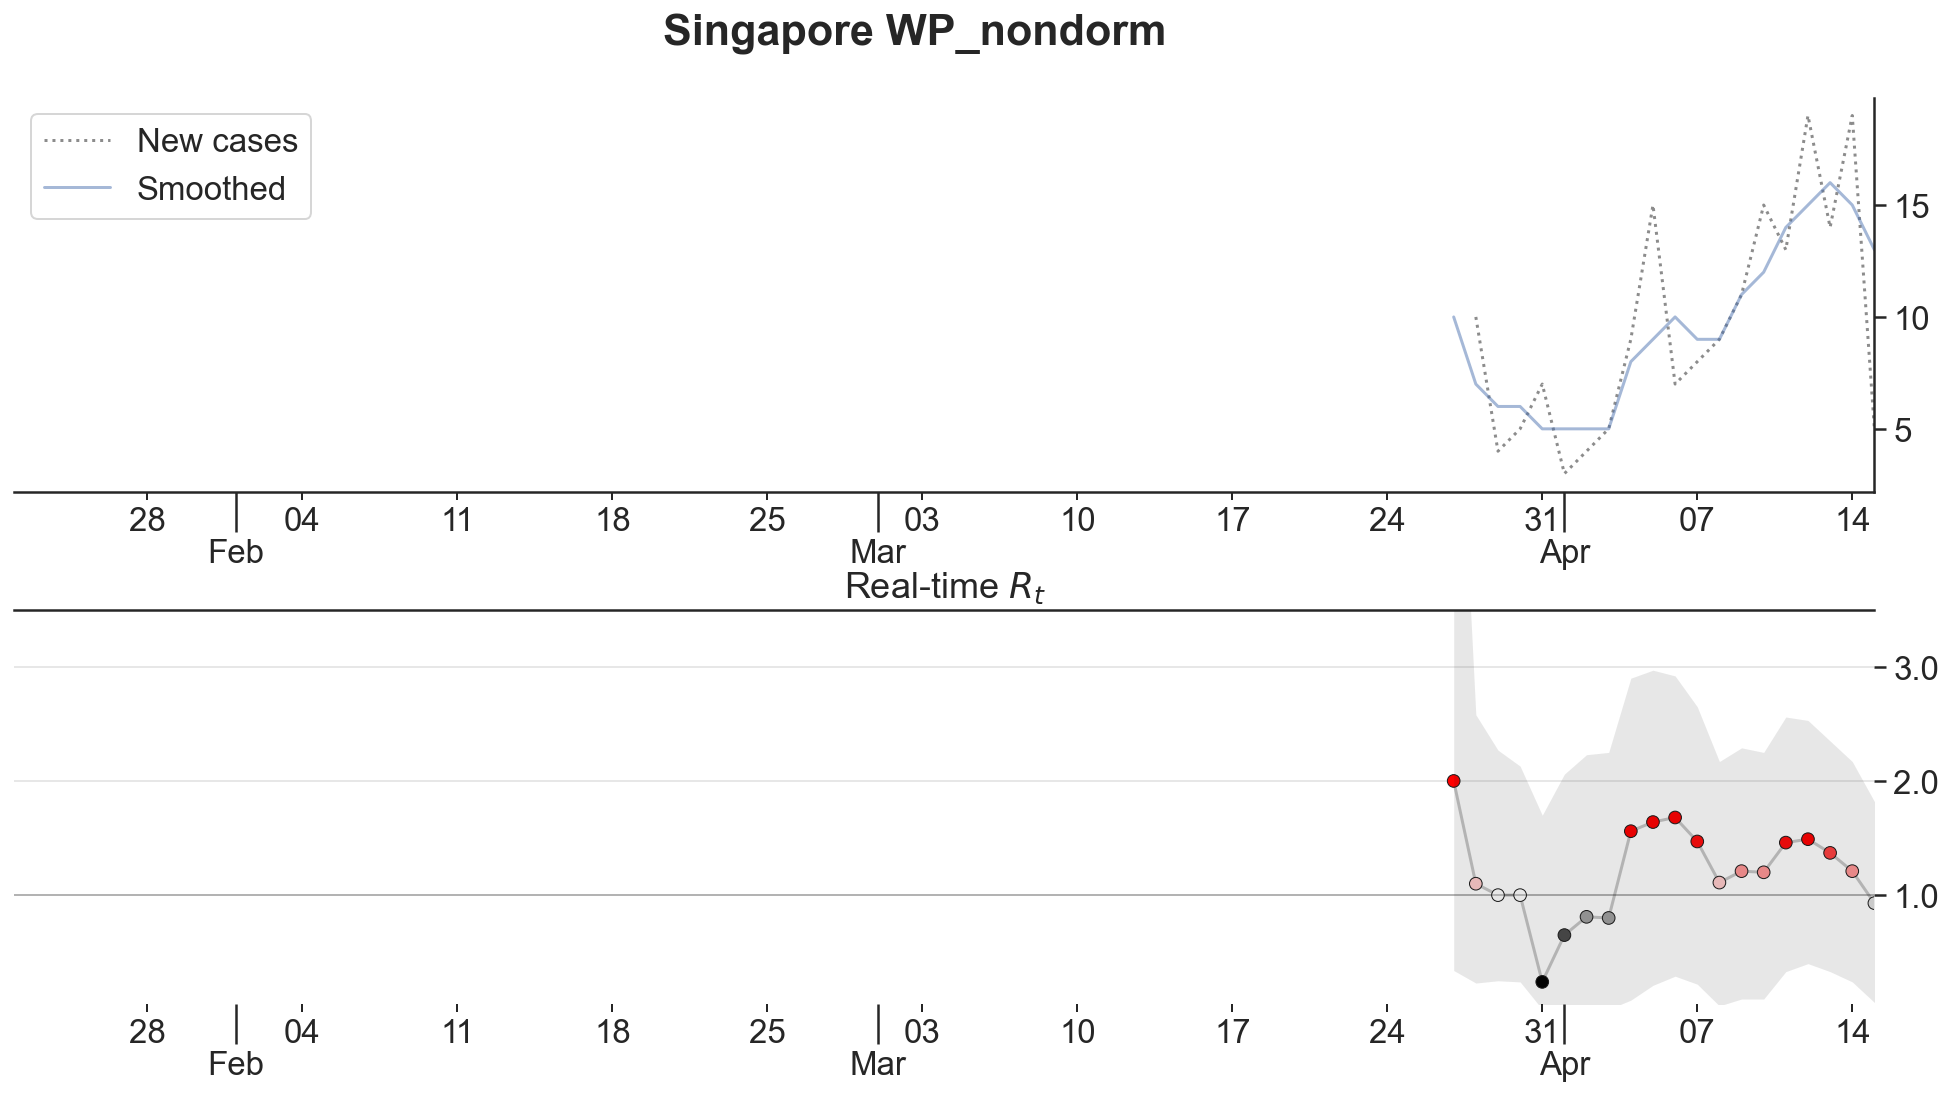

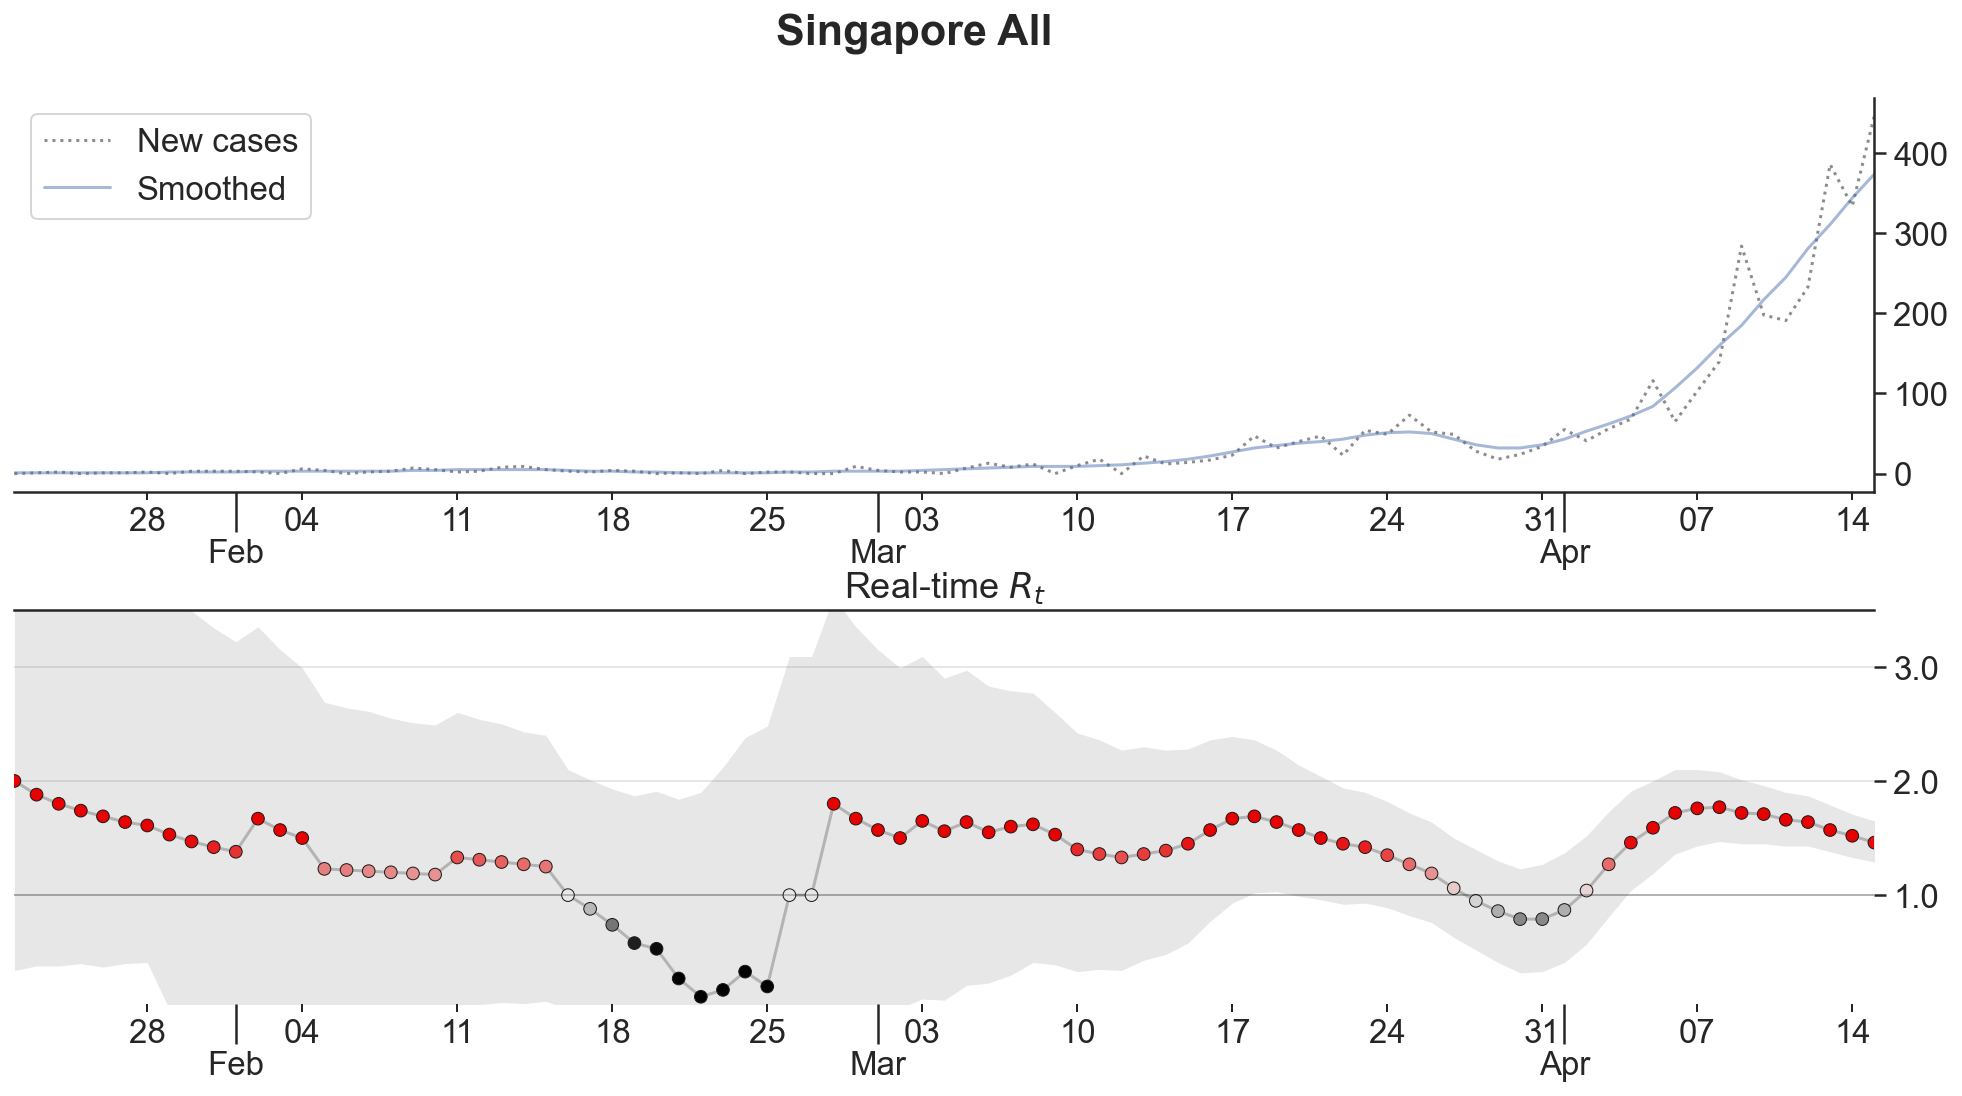

In [195]:
# Create plot.

import seaborn as sns
sns.set(font_scale=1.5, style="ticks")

for j, key in enumerate(all_data_for_plot.keys()):
    
    DATA = all_data_for_plot[key]
    raw = DATA['raw']
    smoothed = DATA['smoothed']
    rt = DATA['rt']
    
    f, axx = plt.subplots(nrows=2, figsize = (1200/72, 600/72),
                         gridspec_kw={"hspace": 0.3})
    

    f.suptitle(f'Singapore {key}', y=0.95, fontweight='bold')
    # Plot the data.
    
    axx[0].plot(raw.index, raw.values, linestyle=":", color='k', 
            zorder=1, alpha=.5, label="New cases")
    
    axx[0].plot(smoothed.index, smoothed.values, color='b',
            zorder=2, alpha=.5, label="Smoothed")
    
    axx[0].legend()
    
#     raw.plot(ax=axx[0], alpha=0.5, linestyle=":", color='k', label="New cases", legend=True)
#     smoothed.plot(ax=axx[0], alpha=0.5, color='b', label="Smoothed", legend=True)
    
#     axx[0].xaxis.set_major_locator(mdates.MonthLocator())
#     axx[0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
# #     axx[0].xaxis.set_minor_locator(mdates.DayLocator())
#     axx[0].xaxis.set_minor_locator(mdates.WeekdayLocator())
#     axx[0].xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
    
    sns.despine(ax=axx[0], right=False, left=True)
        
 
    
    plot_rt(rt, axx[1], key)
    axx[1].set_title(f'Real-time $R_t$')
    axx[1].set_ylim(.05, 3.5)
    
    
   
    
    for a in axx:
        a.set_xlim(all_cases.index[0], all_cases.index[-1])
        a.tick_params(axis='x', which='major', length=20)
        
        a.xaxis.set_major_locator(mdates.MonthLocator())
        a.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        
        a.xaxis.set_minor_locator(mdates.WeekdayLocator())
        a.xaxis.set_minor_formatter(mdates.DateFormatter('%d'))
